# LAB 2.1 - CNS (Hebbian learning)

Import of libraries and fixing of random seed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

np.random.seed(10)

Function able to show the scatter plot with data and vectors related to first principal component eigenvector of data and weights vector.

In [2]:
def data_firstpc_w_plot(ax, data: np.array, first_pc: np.array = None, W: np.array = None) -> None:
    """
    Function able to show the scatter plot with data and vectors related to first principal component eigenvector of data and weights vector.

    ax: Matplotlib axis where write the plot.
    data: Dataset shown in scatter plot.
    first_pc: First principal component eigenvector.
    W: Weights vector.
    """
    ax.scatter(*data)
    if first_pc is not None:
        ax.quiver(*first_pc, color='y', label='First principal component of dataset', width=0.007)
    if W is not None:
        ax.quiver(*W, color='r', label='Weights vector', width=0.005)
    if first_pc is not None or W is not None:
        ax.legend()

Dataset loading and plot in a scatter plot.

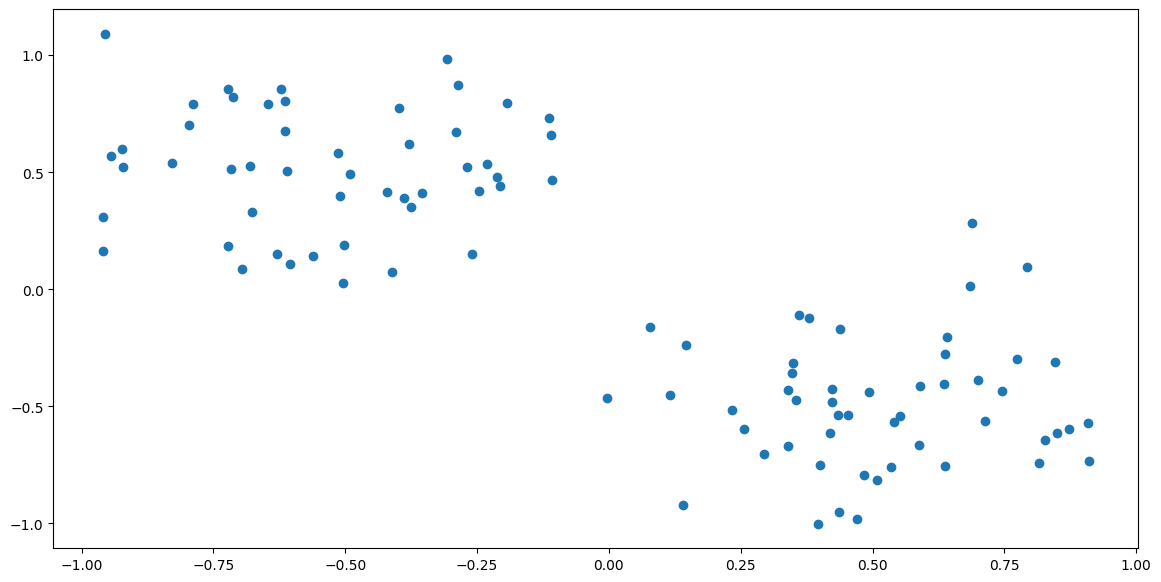

In [3]:
data = pd.read_csv('lab2_1_data.csv', header=None).to_numpy()

plt.figure(figsize=(14, 7))
data_firstpc_w_plot(plt, data=data)
plt.show()

Principal Component Analysis of dataset from the correlation matrix and visualization of first principal component (eigenvector related to the highest eigenvalue).

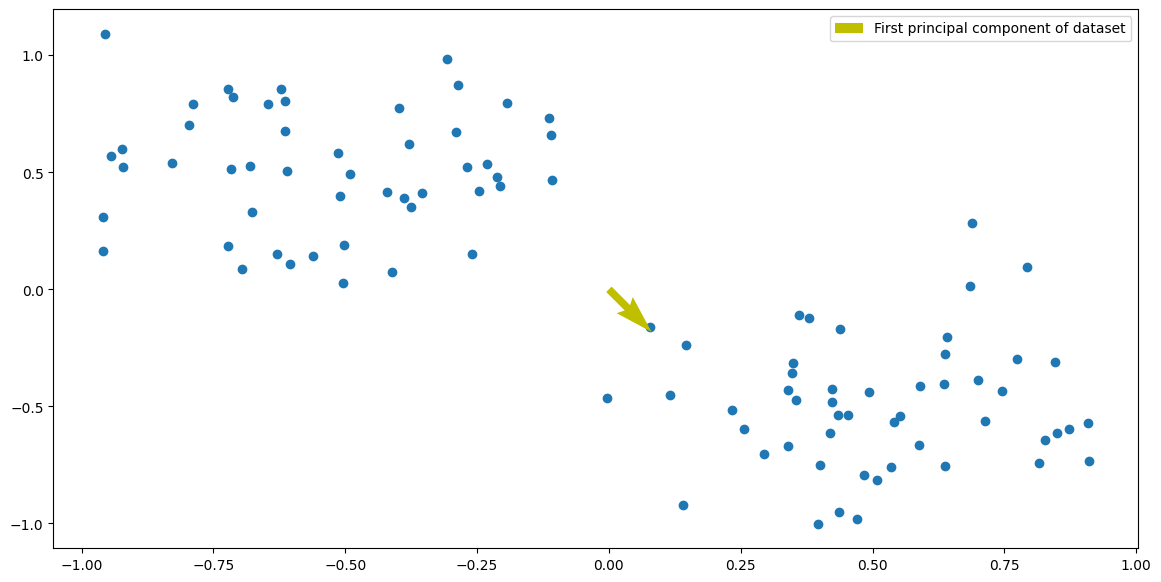

In [4]:
C = np.corrcoef(data)
eig_vals, eig_vects = np.linalg.eig(C)
first_pc = eig_vects.T[eig_vals.argmax()]

plt.figure(figsize=(14, 7))
data_firstpc_w_plot(plt, data=data, first_pc=first_pc)
plt.show()

Weights vector (W) initialization and visualization in data plot.

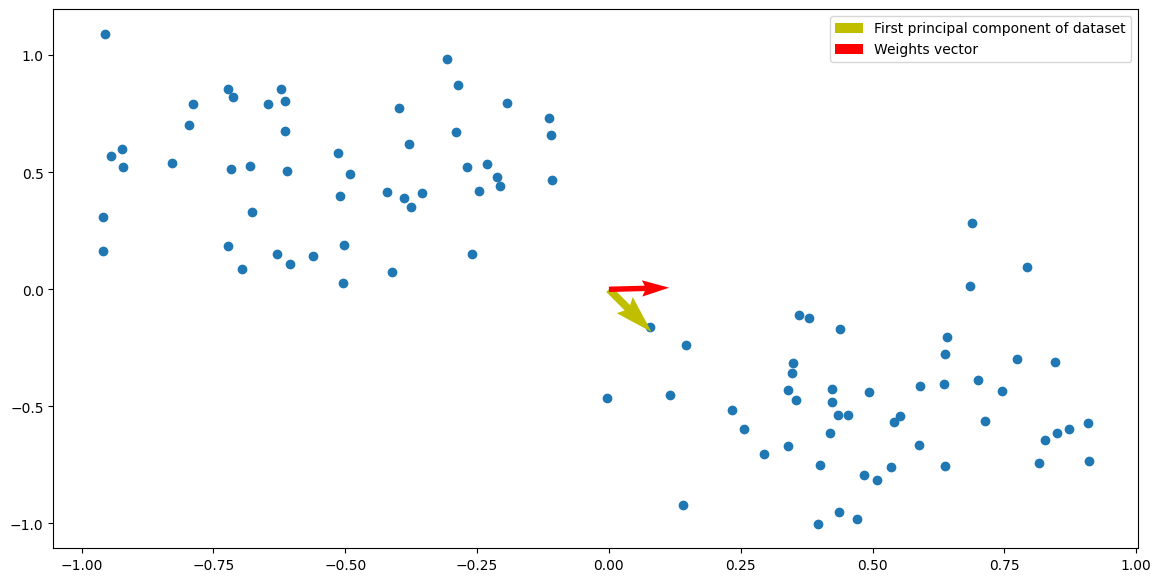

In [5]:
W = np.random.rand(data.shape[0])

plt.figure(figsize=(14, 7))
data_firstpc_w_plot(plt, data=data, first_pc=first_pc, W=W)
plt.show()

Function able to plot the analysis on weights vector. This function is able to show 4 plots:
1. Scatter plot of data with first principal component eigenvector and weights vector.
2. Change of weights norm over time.
3. Change of first weights vector component (x) over time.
4. Change of second weights vector component (y) over time.

In [6]:
def plot_analysis(weights_evolution: np.array, title: str, save: bool = True) -> None:
    """
    Plot able to plot the entire analysis on list of evolution of weights vectors.

    weights_evolution: List of weights vectors for each step of training.
    title: Title of plot.
    save: Flag to save the plot as a file.
    """
    plt.figure(figsize=(20, 20))
    plt.suptitle(title)

    ax = plt.subplot(3, 2, 1)
    ax.set_title('Data, first component of PCA and weights vector')
    data_firstpc_w_plot(ax, data=data, first_pc=first_pc, W=weights_evolution[-1])

    x = list(range(len(weights_evolution)))
    ax = plt.subplot(3, 2, 2)
    ax.set_title('Weights norm')
    ax.grid(True)
    ax.plot(x, [np.linalg.norm(w) for w in weights_evolution])
    ax.set_xlabel('Learning steps')
    ax.set_ylabel('Weights norm')

    ax = plt.subplot(3, 2, 3)
    ax.set_title('First component of weights vector - x axis')
    ax.grid(True)
    ax.plot(x, [w[0] for w in weights_evolution])
    ax.set_xlabel('Learning steps')
    ax.set_ylabel('Weights first component')

    ax = plt.subplot(3, 2, 4)
    ax.set_title('Second component of weights vector - y axis')
    ax.grid(True)
    ax.plot(x, [w[1] for w in weights_evolution])
    ax.set_xlabel('Learning steps')
    ax.set_ylabel('Weights second component')

    if save:
        plt.savefig(f'hebbian_learning_assets/plots/{title}.png')

Function able to train the weights vector given a learning rule and collect the list of weights vector evolution over time.

In [7]:
def train(
        dataset: np.array,
        w: np.array,
        learning_rule: Callable,
        epochs: int = 500, lr: float = 1e-3,
        weights_threshold: float = 1e-8,
        filename: str = None
) -> np.array:
    """
    dataset: Dataset.
    w: Weights vector.
    learning_rule: Learning rule callback.
    Epochs: Maximum number of epoch.
    lr: Learning reate.
    weights_threshold: Threshold to stop training if the norm of difference between new and old weights is under it.
    filename: Name of file where save the matrix of weights evolution.

    returns:
        np.array: Weights evolution.
    """
    weights_evolution = [w]
    for epoch in range(epochs):
        dataset = np.random.permutation(dataset.T).T
        for u in data.T:
            v = w.T @ u
            delta_w = learning_rule(v, u, w)
            w_new = w + lr * delta_w
            if np.linalg.norm(w_new - w) < weights_threshold:
                return weights_evolution
            else:
                w = w_new
            weights_evolution.append(w)
    weights_evolution = np.array(weights_evolution)
    if filename is not None:
        np.save(f'hebbian_learning_assets/output_data/{filename} - weights evolution', weights_evolution)
    return weights_evolution

## Assignment 1 - Basic Hebbian learning

Analysis with basic Hebbian rule. We can see that weights vector is parallel to the first principal component eigenvector as expected. The other plots shows the unstable nature of this learning rule because first component, second component and norm of weights vector grow without reach a bound.

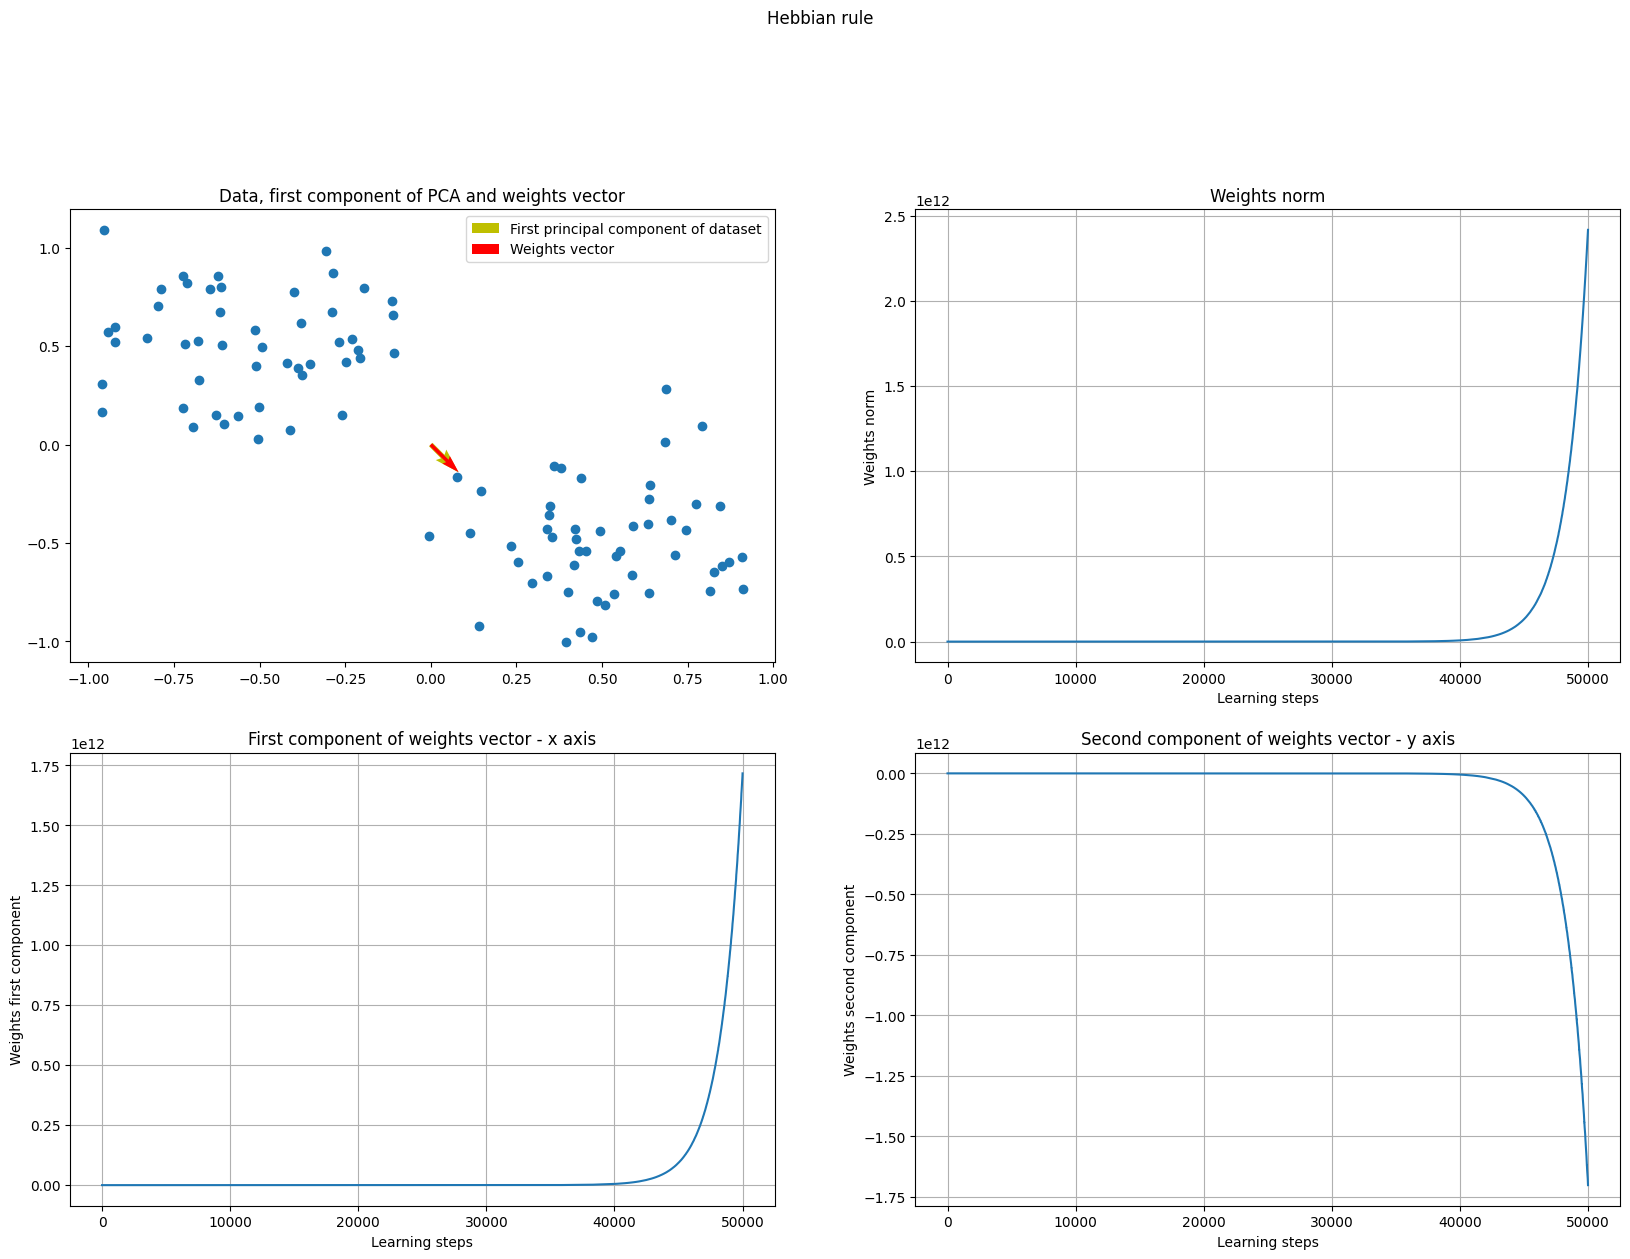

In [8]:
title = 'Hebbian rule'
basic_hebbian_rule = lambda v, u, w: v * u

weights_over_time = train(data, W, learning_rule=basic_hebbian_rule, filename=title)
plot_analysis(weights_over_time, title=title)

## Assignment 2 - Oja rule

Analysis with Oja rule. We can see that weights vector is parallel to the first principal component eigenvector as expected. The other plots shows the stable nature of this learning rule because first component, second component and norm of weights vector reach a bound and stabilize there. Changing the value of alpha we can see that using a higher value the stabilization is faster and reach a stabilization point closer to zero.

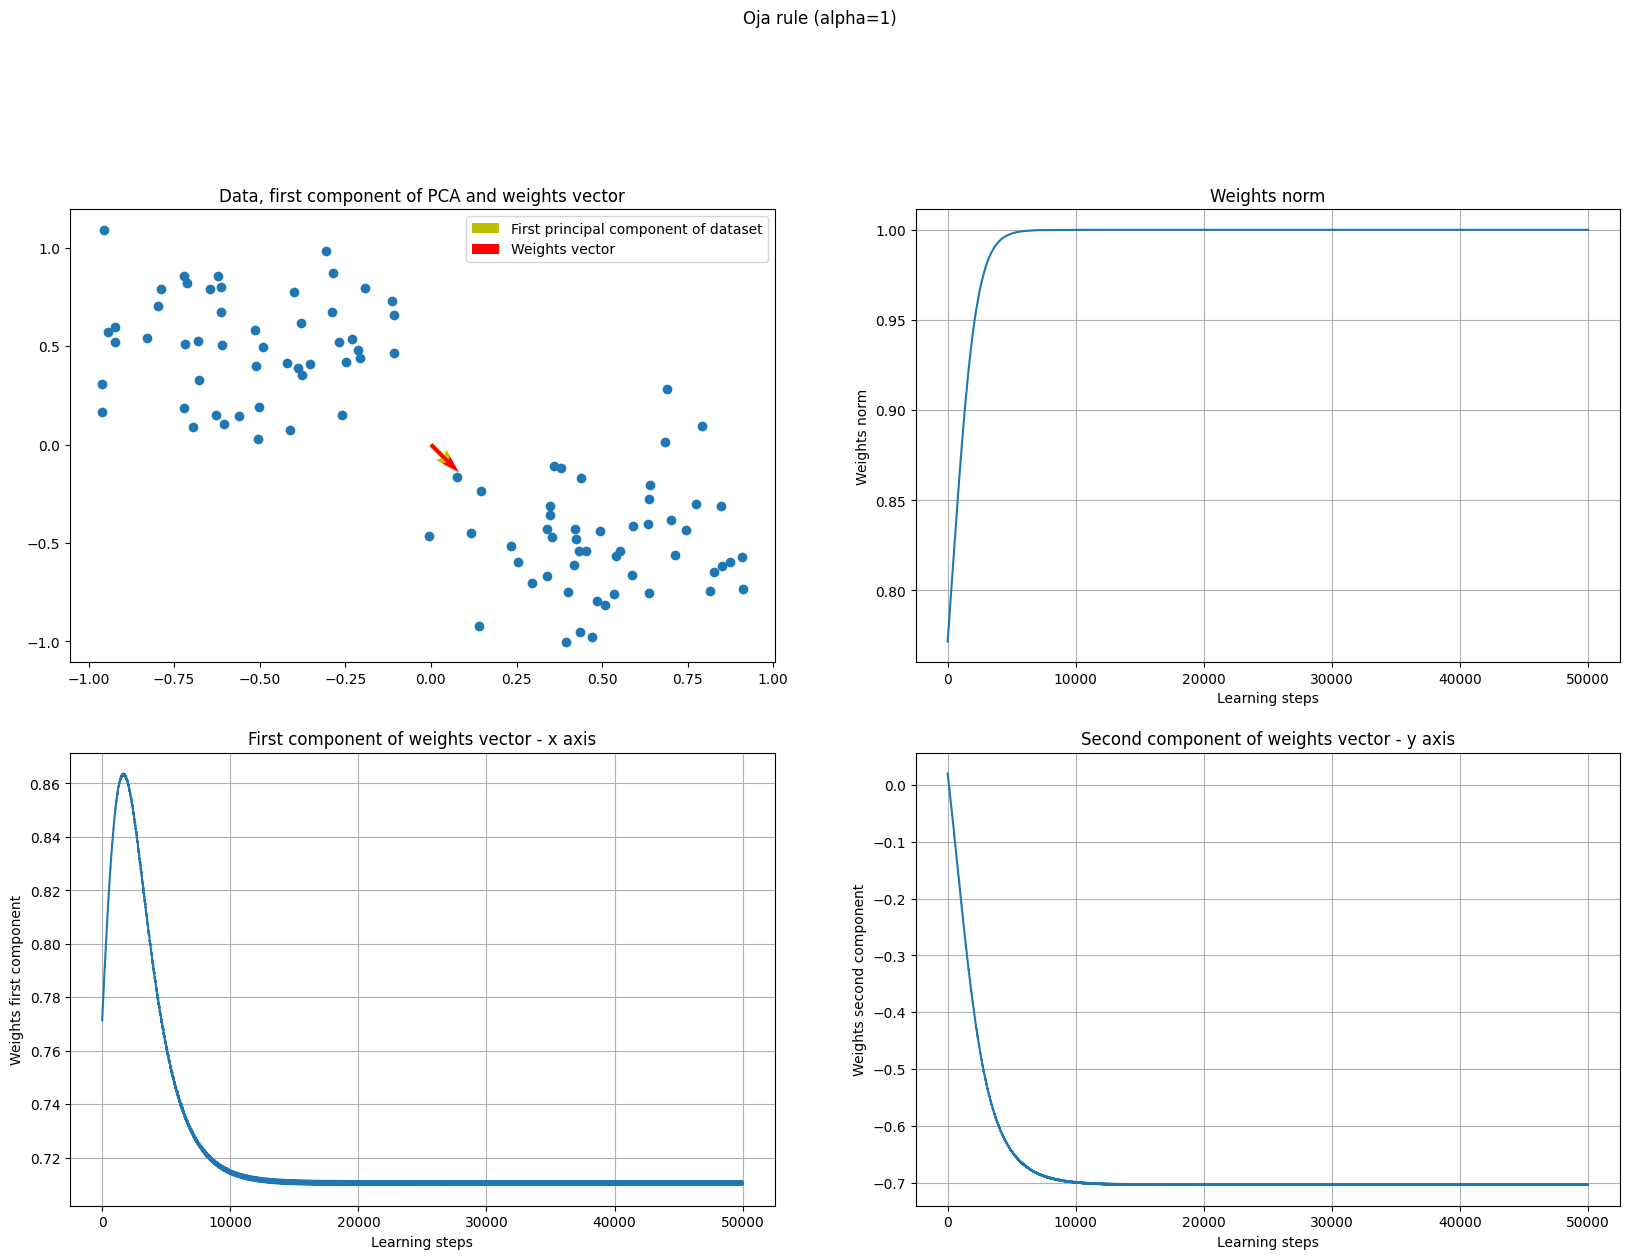

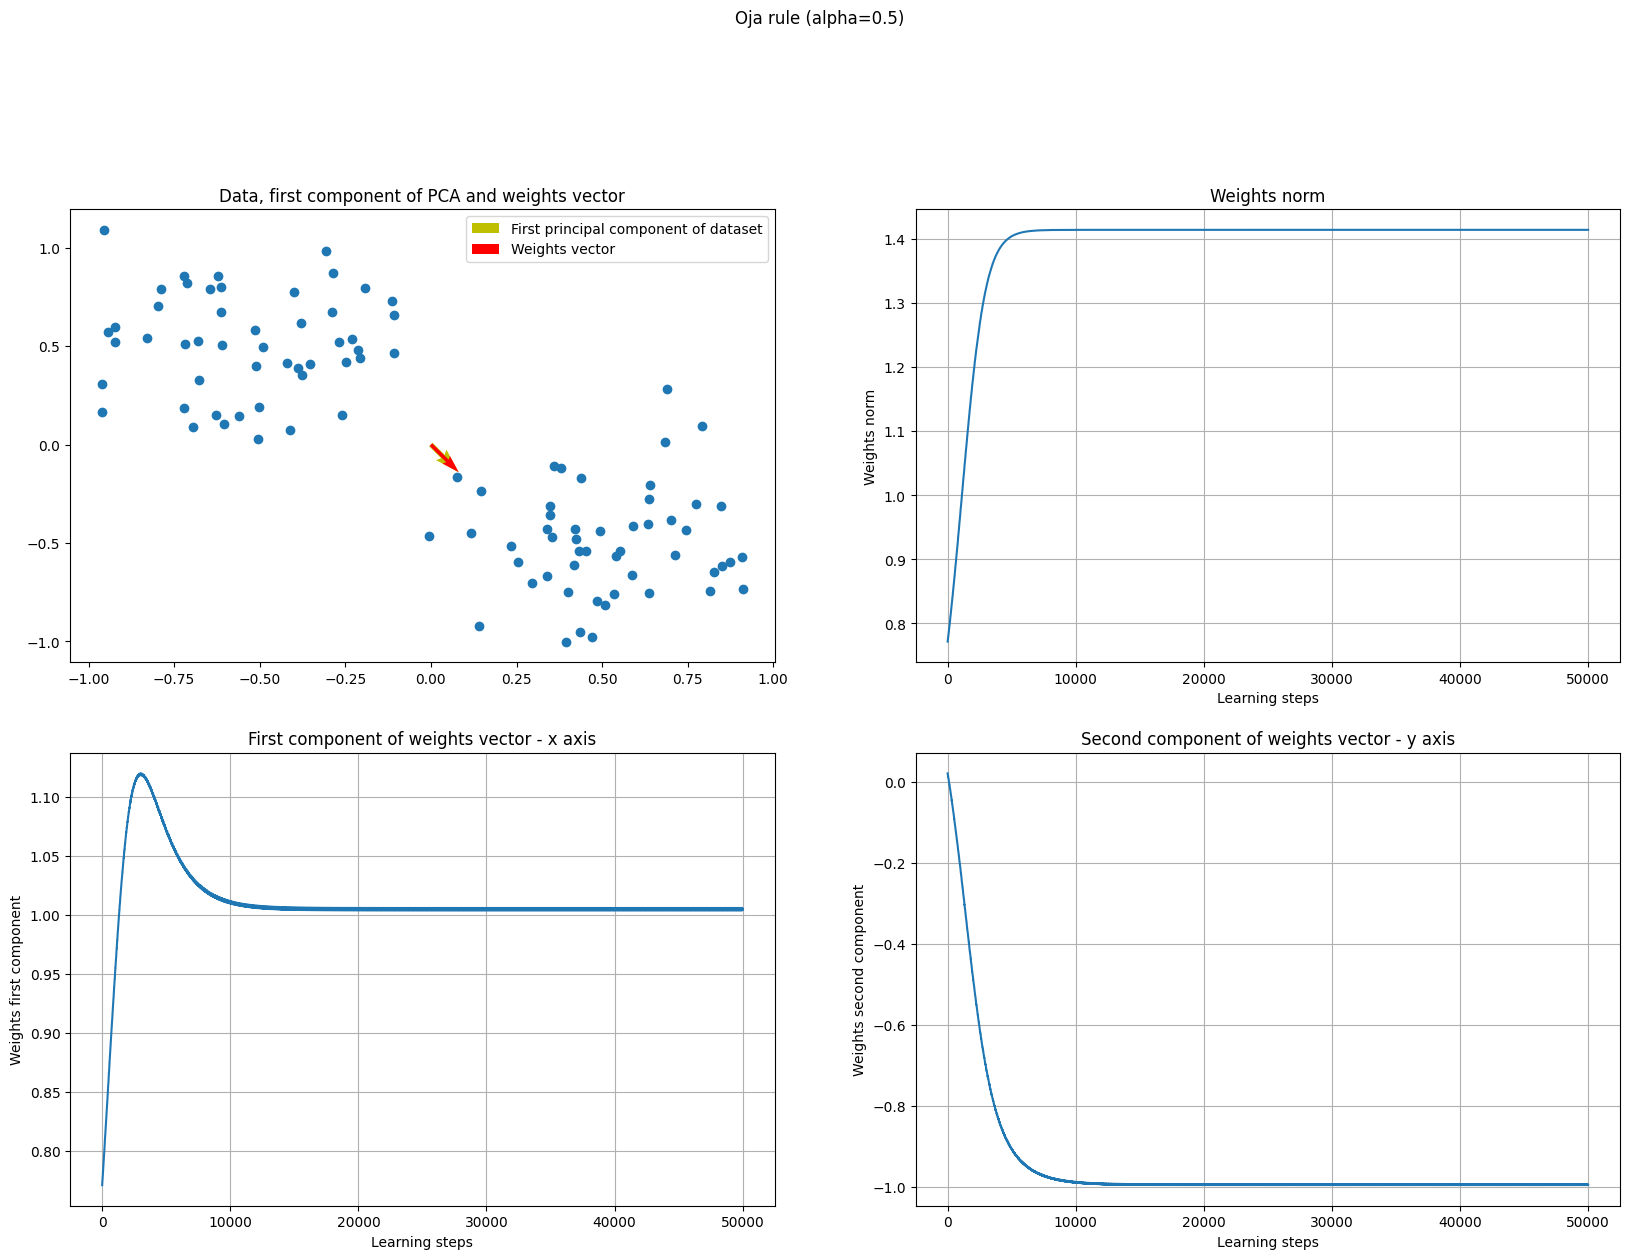

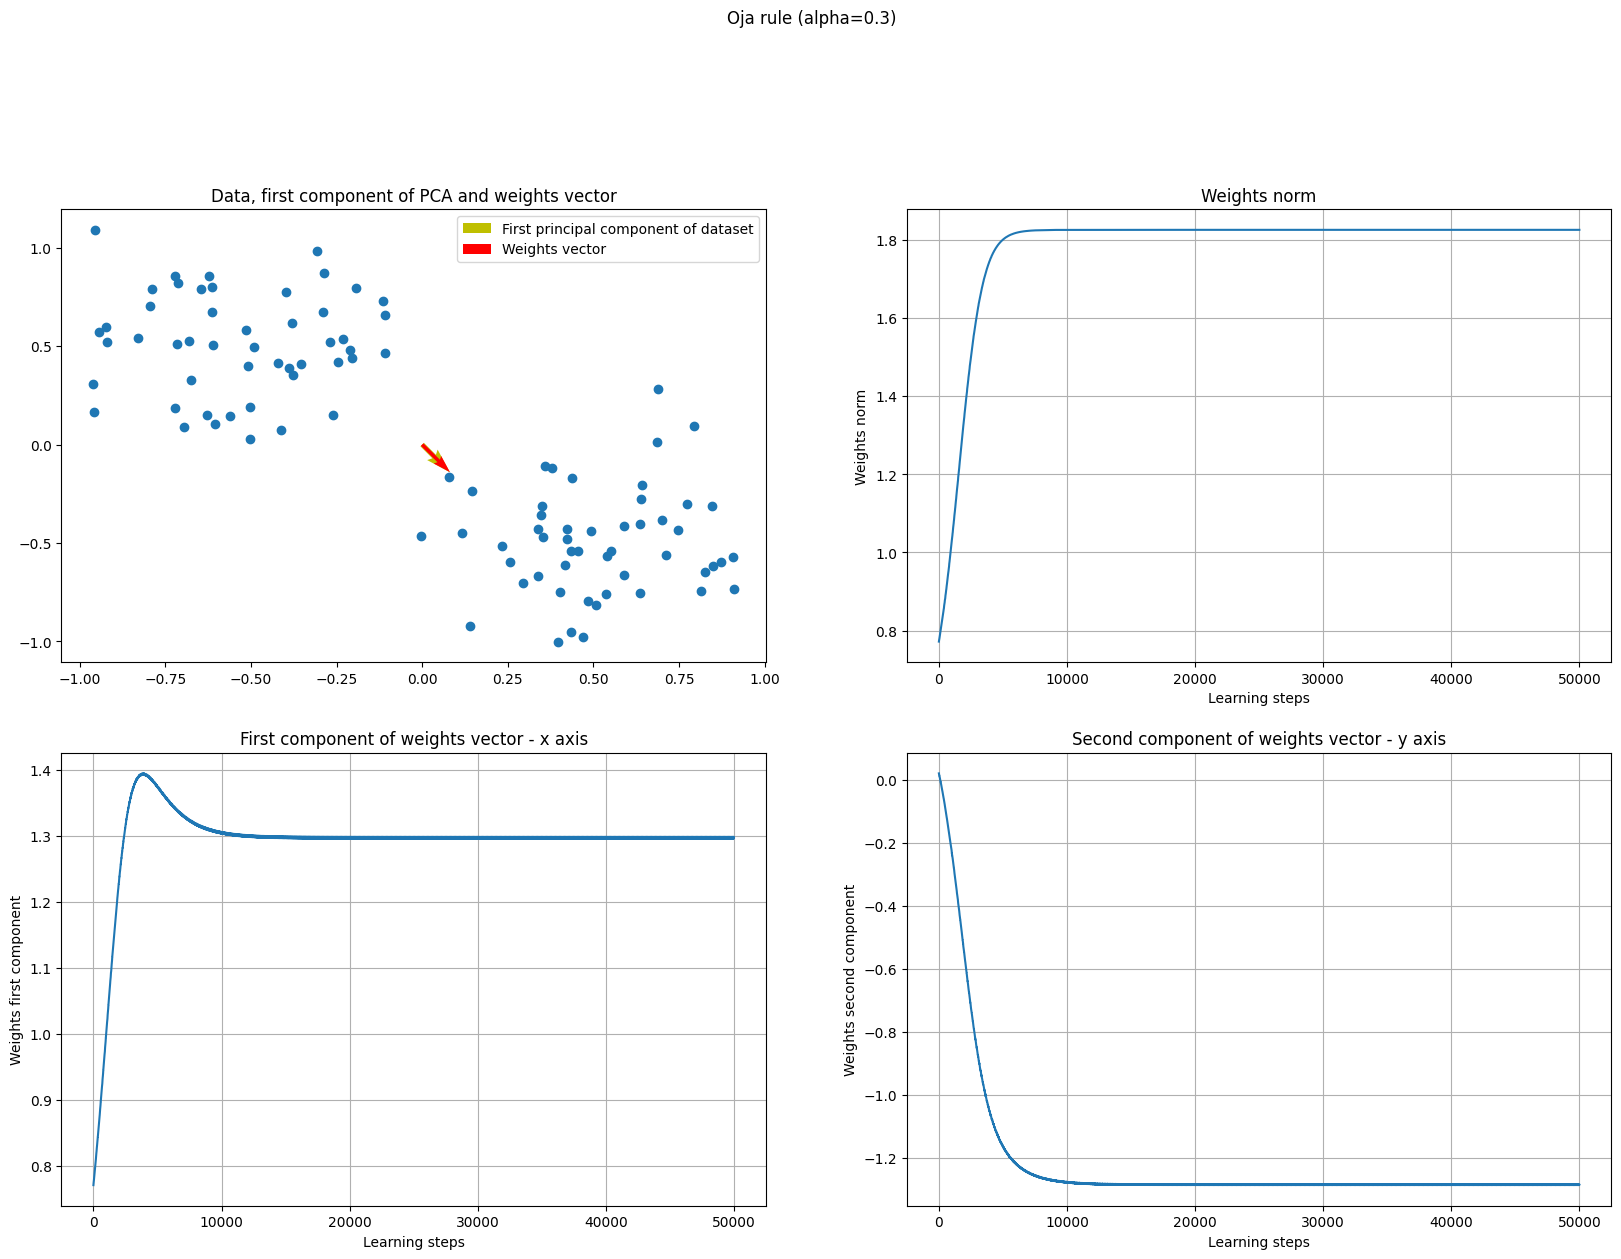

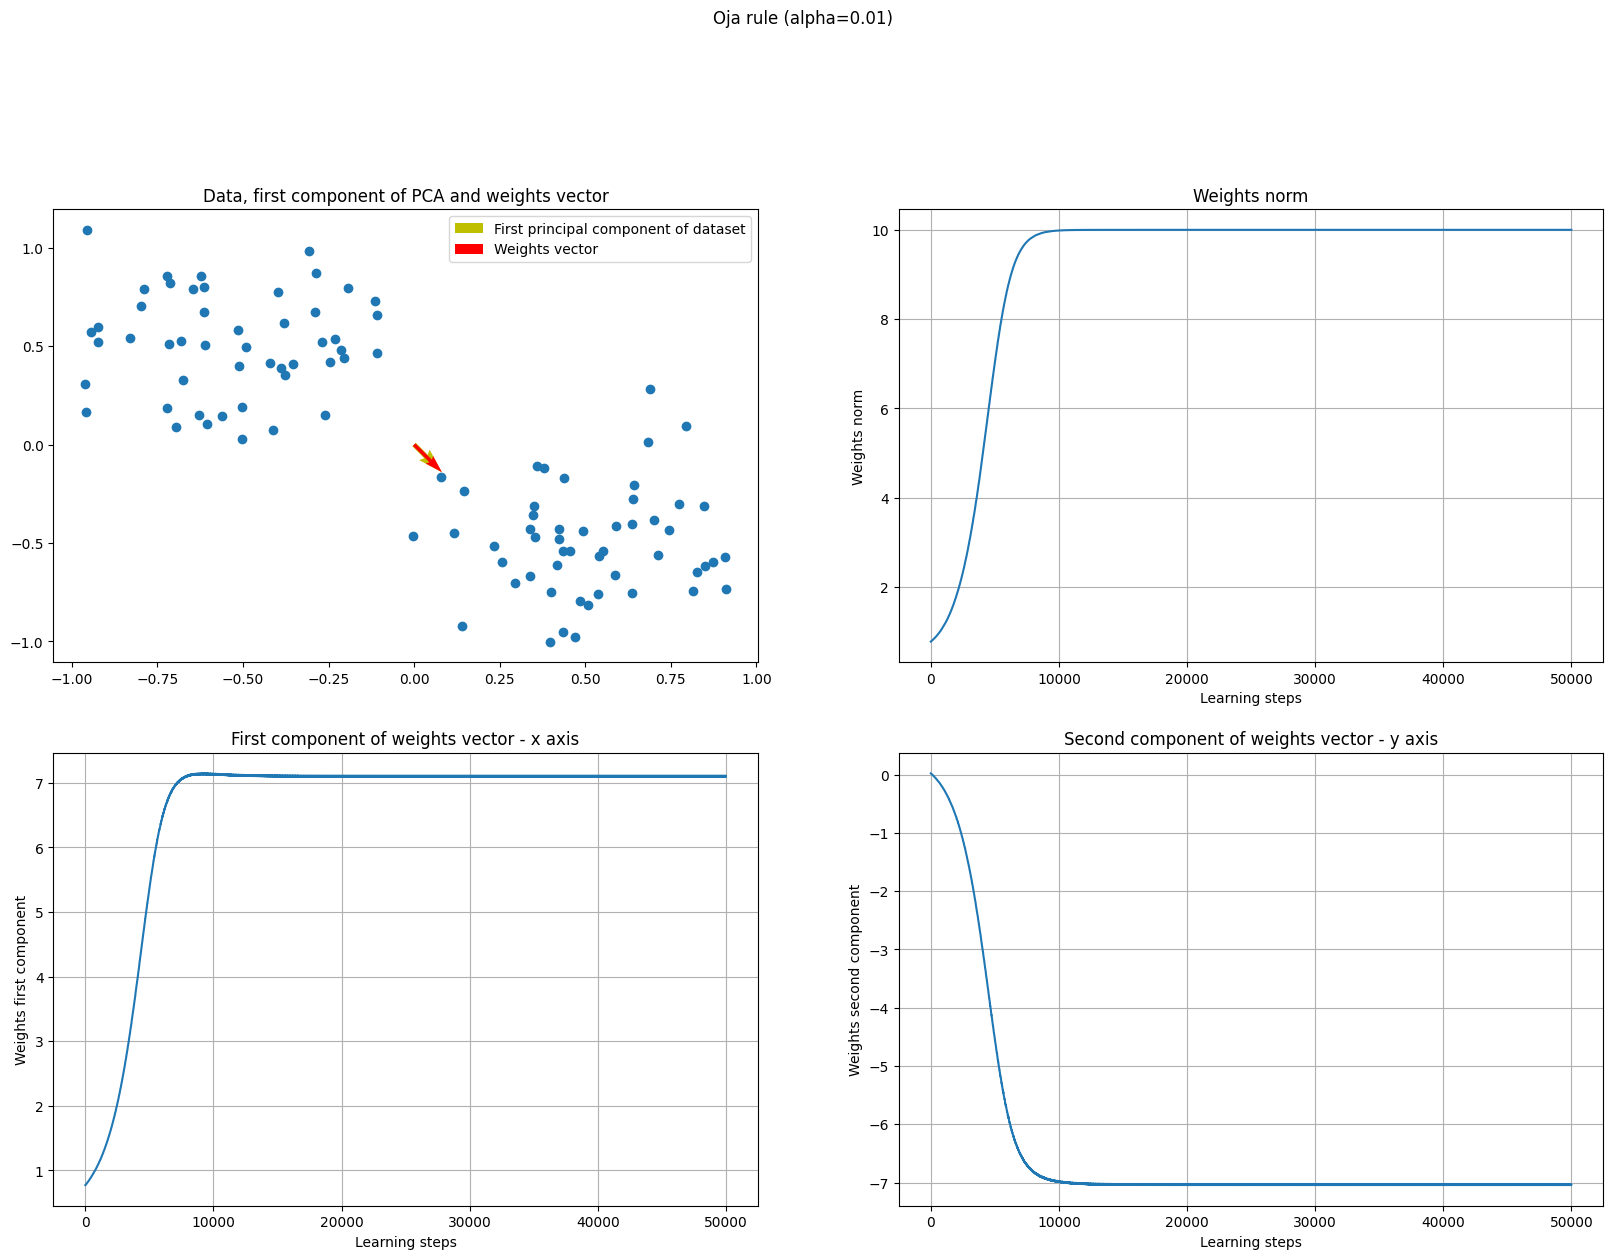

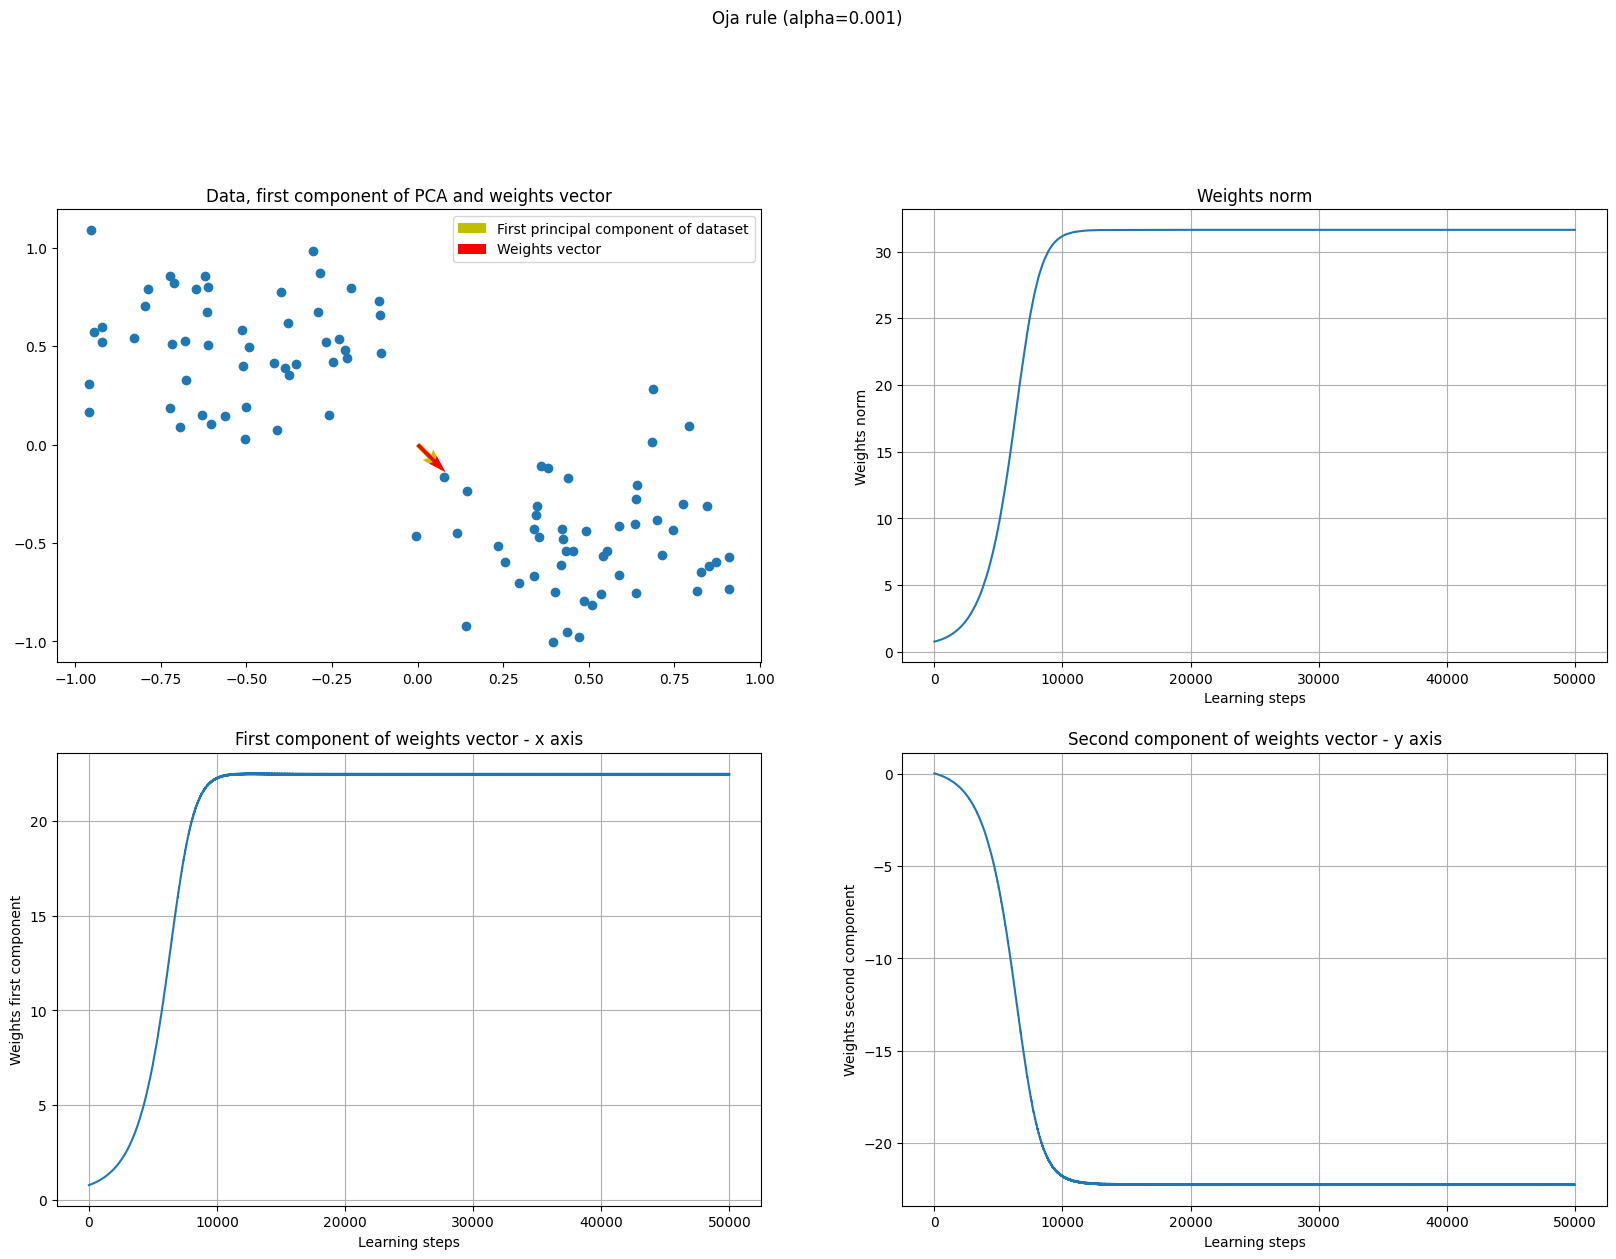

In [9]:
for alpha in [1, 0.5, 0.3, 0.01, 0.001]:
    title = f'Oja rule (alpha={alpha})'
    oja_rule = lambda v, u, w: v * u - alpha * v ** 2 * w

    weights_over_time = train(data, W, learning_rule=oja_rule, filename=title)
    plot_analysis(weights_over_time, title=title)

## Assignment 3 - Subtractive normalization

Analysis with subtractive normalization rule. We can see that weights vector is parallel to the first principal component eigenvector as expected. In the other plots the values on first component, second component and norm of weights vector grow in an unbounded way. This rule is able to control the sum of weights as we can see in the last plot.

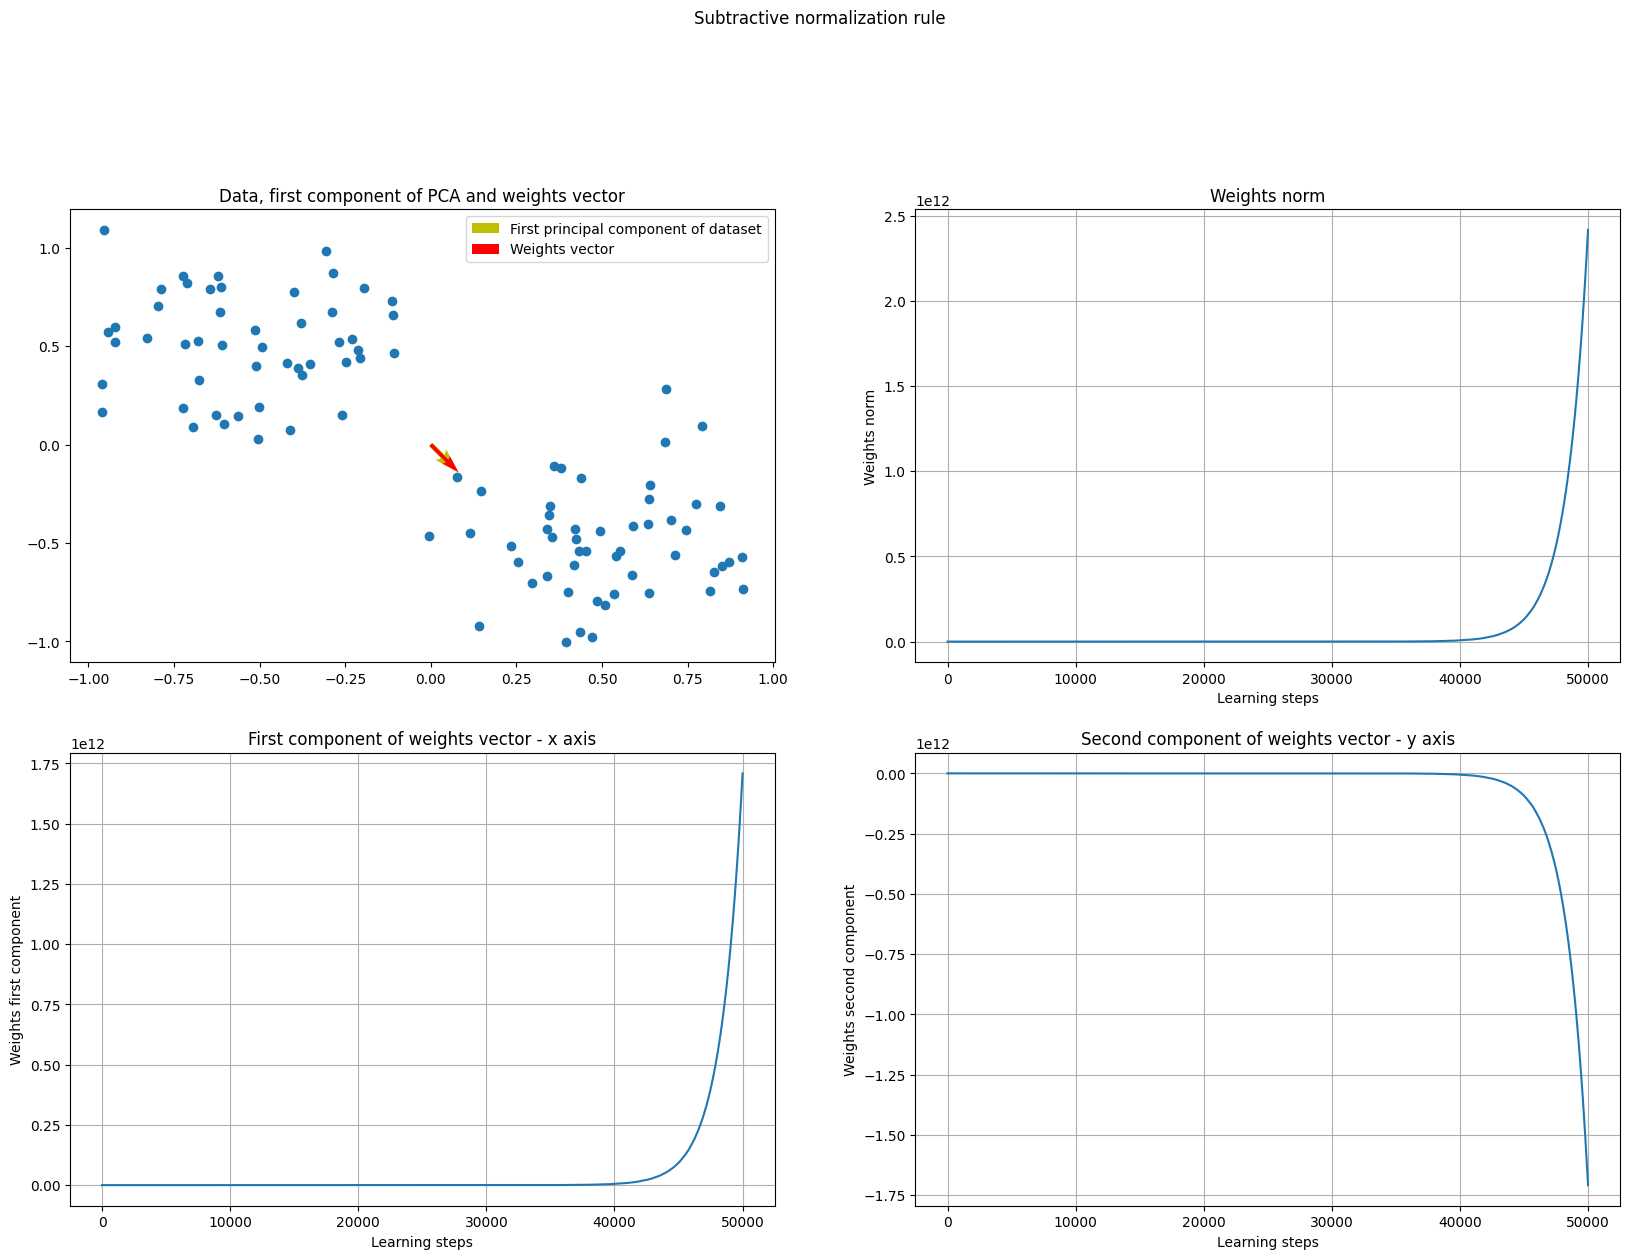

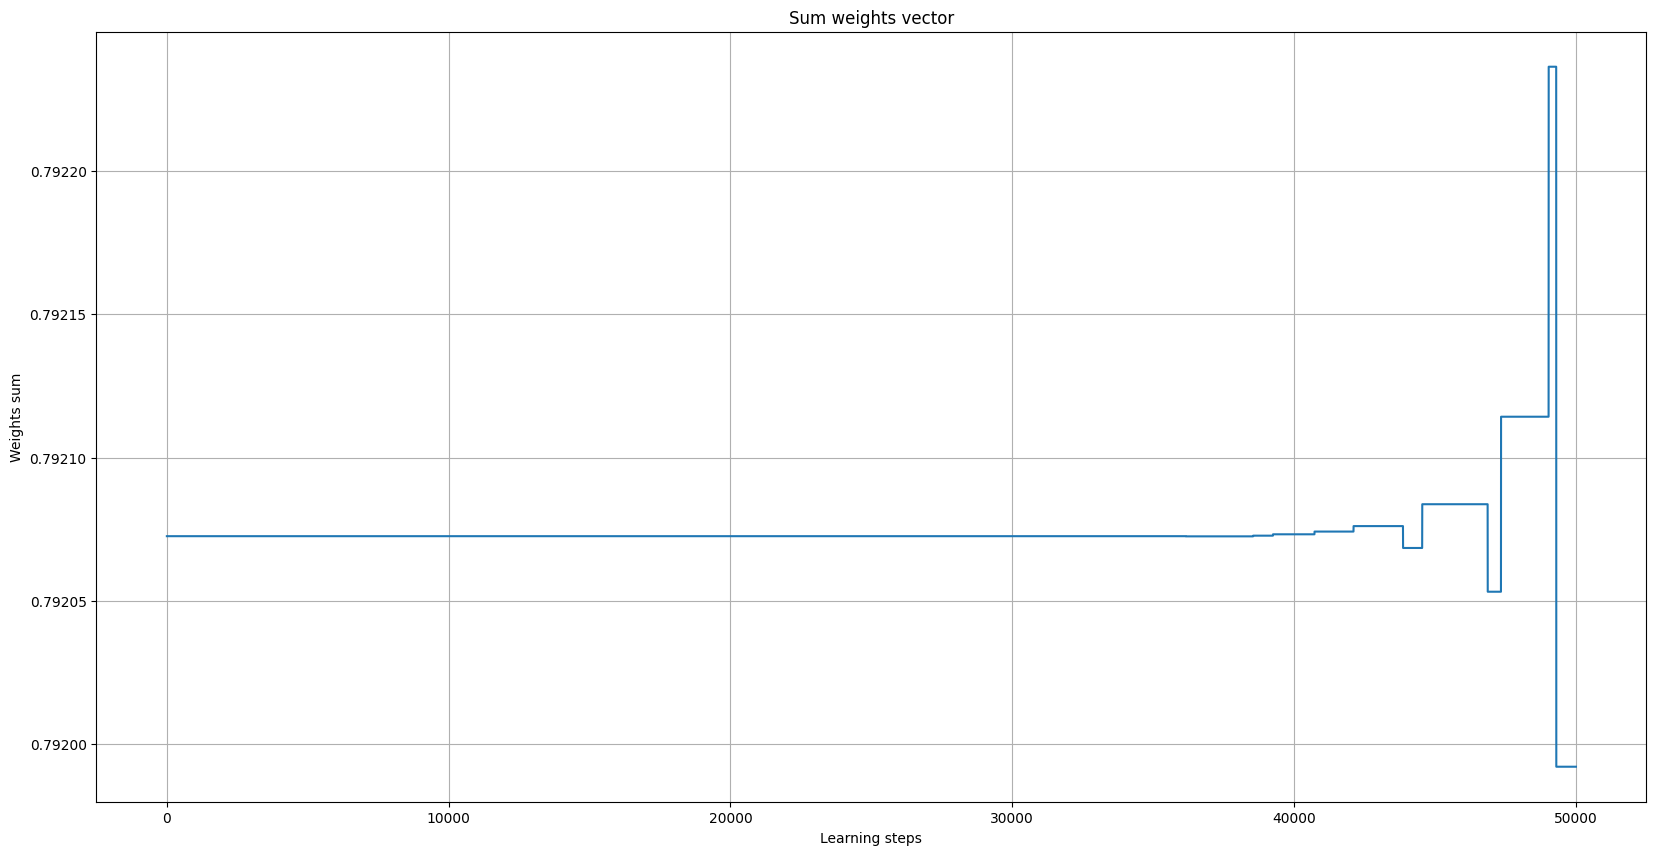

In [10]:
title = 'Subtractive normalization rule'
n = np.ones(data.shape[0])
subtractive_normalization = lambda v, u, w: v * u - ((v * (n.T @ u) * n) / 2)

weights_over_time = train(data, W, learning_rule=subtractive_normalization, filename=title)
plot_analysis(weights_over_time, title=title)

plt.figure(figsize=(20, 10))
plt.title('Sum weights vector')
plt.grid(True)
plt.plot(list(range(weights_over_time.shape[0])), [w.sum() for w in weights_over_time])
plt.xlabel('Learning steps')
plt.ylabel('Weights sum')

plt.show()